In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os
import re
import json

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

import nltk
from nltk import SnowballStemmer
from nltk.corpus import stopwords

import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks


from sklearn.utils import shuffle

In [2]:
SHUFFLE_RANDOM_STATE = 42
TRAIN_RANDOM_STATE = 42
SGD_RANDOM_STATE = 42

SGD_MAX_ITER = 1000

TEXT = 'Sentence'
FILTER = 'Entity'
START_TOKEN = 'START'
TOKEN_LEN = 'LEN'
Y_HEADER = 'LABEL'
LABELS = {
    "NEG": 0,
    "SEM": 1,
    "POZ": 2
}

EKEZET_VALTAS_RAGNAL = {
    'a': 'á',
    'e': 'é'
}

In [3]:
# Text processing

def extend_context(text, context, left_index, right_index):
    # TODO: Mi van, ha a neveket sem vesszuk bele?
    global fix
    if type(text) != list:
        text = text.split()
    start_size = 0
    while start_size < 10:
        if left_index > 0:
            left_index -= 1
            context.insert(0, text[left_index])
            if len(text[left_index]) > 1:
                start_size += 1
        if right_index < len(text) -1:
            right_index += 1
            context.append(text[right_index])
            if len(text[right_index]) > 1:
                start_size += 1
        if left_index <= 0 and right_index >= len(text) -1:
            break
    return ' '.join(context)

def contextualize(index, debug = False):
    global fix
    text = ' '.join([i for i in re.split(r'( - |(?![%.-])\W)|(-e[\n ])', dataset[TEXT][index]) if i])
    context_start_index = int(dataset[START_TOKEN][index] - 1)
    context_stop_index = int(context_start_index+dataset[TOKEN_LEN][index] - 1)

    context_name_tokens = \
        [t for t in text
                        .split()[context_start_index:context_stop_index+1]]

    context_name = ' '.join(context_name_tokens)
    context_filter = dataset[FILTER][index]

    # Ha ragozunk, akkor a-bol á lesz pl Csaba -> Csabával
    if len(context_name) >= len(context_filter) \
            and context_filter[len(context_filter)-1] in EKEZET_VALTAS_RAGNAL\
            and EKEZET_VALTAS_RAGNAL.get(context_filter[len(context_filter)-1]) == context_name[len(context_filter)-1]:
        context_filter = context_filter[:-1] + context_name[len(context_filter)-1]

    context_list = context_name_tokens
    left_index = context_start_index
    right_index = context_stop_index
    context = extend_context(text, context_list, left_index, right_index)
    return context

In [4]:

# Load and set up data

dataset = pd.read_csv('db/train.csv', sep=';')
dataset = shuffle(dataset, random_state=SHUFFLE_RANDOM_STATE)
dataset.info()

X_list = []
print(len(dataset.index))
for i  in range(len(dataset.index)):
    X_list.append(contextualize(i))

X = np.asarray(X_list)
y = dataset[Y_HEADER].values


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=TRAIN_RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7700 entries, 3856 to 7270
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        7700 non-null   int64 
 1   START     7700 non-null   int64 
 2   LEN       7700 non-null   int64 
 3   Entity    7700 non-null   object
 4   Sentence  7700 non-null   object
 5   URL       7700 non-null   object
 6   LABEL     7700 non-null   object
dtypes: int64(3), object(4)
memory usage: 481.2+ KB
7700


dict_values([1070, 533, 4557])


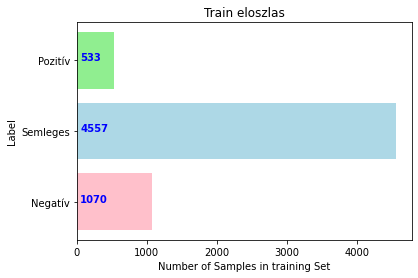

dict_values([263, 130, 1147])


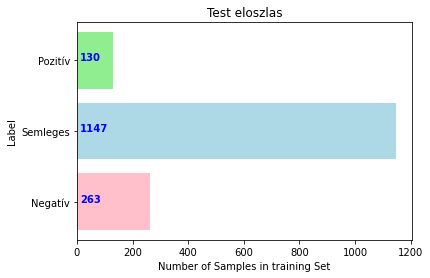

In [5]:
def plot_label_counts(y, title='y labels'):
    unique, counts = np.unique(y, return_counts=True)
    b = dict(zip(unique, counts))
    b_values = [b['NEG'], b['SEM'], b['POZ']]
    print(b.values())
    plt.barh(range(len(b)), b_values, align='center', color=['pink', 'lightblue', 'lightgreen'])
    y_values = ["Negatív", "Semleges", "Pozitív"]
    y_axis = np.arange(0, 3, 1)
    plt.yticks(y_axis, y_values)
    plt.title(title)
    plt.xlabel('Number of Samples in training Set')
    plt.ylabel('Label')
    ax = plt.gca()
    for i, v in enumerate(b_values):
        plt.text(ax.get_xlim()[1]/100, i, str(v), color='blue', fontweight='bold')
    plt.show()

plot_label_counts(y_train, 'Train eloszlas')
plot_label_counts(y_test, 'Test eloszlas')

In [6]:
def evaluate(predict, labels):
    print('Classification report:')
    print(classification_report(labels, predict))
    print('Accuracy:')
    print(accuracy_score(labels, predict))

    print('Confusion matrix:')
    df_cm = pd.DataFrame(confusion_matrix(labels, predict, labels=['POZ', 'SEM', 'NEG']),
                         index=[i for i in ['POZ', 'SEM', 'NEG']],
                         columns=[i for i in ['POZ', 'SEM', 'NEG']],)
    plt.figure(figsize=(10,7))
    hm = sn.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    hm.set(ylabel='True label', xlabel='Predicted label')
    plt.show()

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel_Janos_Robert\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:

all_stopwords = []

def create_corpus_by_dataset(sentences):
    global all_stopwords
    corpus = []
    for sen in sentences:
        sentence = re.sub('[^a-zA-ZöÖüÜóÓőŐúÚáÁűŰéÉíÍ]', ' ', sen)
        sentence = sentence.lower().split()
        all_stopwords = stopwords.words('hungarian')
        whitelist = ["ne", "nem", "se", "sem"]
        sentence = [word for word in sentence if (word not in all_stopwords or word in whitelist)
                 and len(word) > 1]
        ps = SnowballStemmer('hungarian')
        sentence = [ps.stem(word) for word in sentence]
        sentence = ' '.join(sentence)
        corpus.append(sentence)

    return corpus

X_train_clean = create_corpus_by_dataset(X_train)
X_test_clean = create_corpus_by_dataset(X_test)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0.002, ngram_range=(1,3)) #ngram (1-3)
x_train_model = cv.fit_transform(X_train_clean)

In [10]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(random_state=SGD_RANDOM_STATE, max_iter=SGD_MAX_ITER, learning_rate='constant',
                           eta0=0.01, class_weight='balanced')
classifier.fit(x_train_model, y_train)

SGDClassifier(class_weight='balanced', eta0=0.01, learning_rate='constant',
              random_state=42)

Classification report:
              precision    recall  f1-score   support

         NEG       0.19      0.09      0.12       263
         POZ       0.13      0.13      0.13       130
         SEM       0.75      0.84      0.79      1147

    accuracy                           0.65      1540
   macro avg       0.36      0.35      0.35      1540
weighted avg       0.60      0.65      0.62      1540

Accuracy:
0.6519480519480519
Confusion matrix:


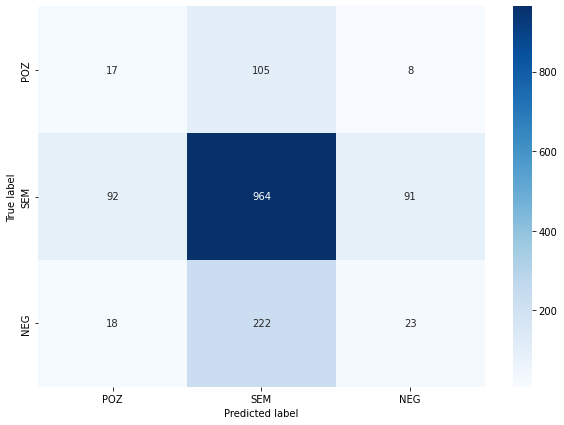

In [11]:
x_dev_model = cv.transform(X_test_clean)

dev_predict = classifier.predict(x_dev_model)

evaluate(dev_predict, y_test)